In [1]:
import os
import parameter
import pandas as pd
import simplejson
import pickle
from cluster_model import ClusterModel
from datetime import timedelta

In [2]:
with open('../data/station_data/2024 model/v2/tph_4/data.pickle', 'rb') as f:
    station_data = pickle.load(f)

with open('../station_information.json', 'r') as f:
    station_information = simplejson.load(f)['data']['stations']
    
model = ClusterModel(station_data=station_data, in_transit=[], tph=4)
model.init_clusters(0.005)

36 horizontal squares and 51 vertical squares. Total squares: 1836


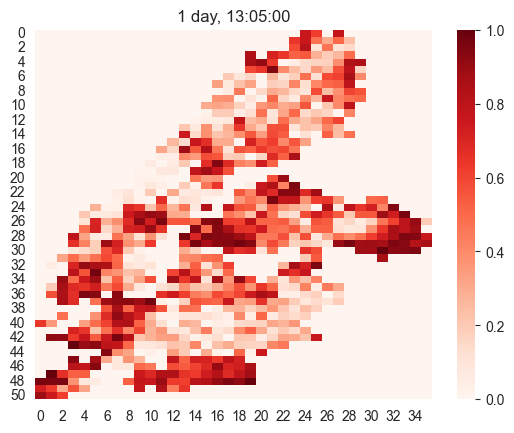

In [28]:
day = 8
files = os.listdir(f'rebalancing/data/{day}')
files.sort()
for i, file in enumerate(files[::3]):
    df = parameter.get_state_df(station_information, f'rebalancing/data/{day}/' + file,)
    split_file = file[:-7].split('-')
    hour = int(split_file[3])-4
    minute = int(split_file[4])
    model.init_df_state(df, time=timedelta(hours=(hour+minute/60)))
    if i < 10:
        i = f'00{i}'
    elif i < 100:
        i = f'0{i}'
    else:
        i = f'{i}'
    model.show_fill_percent(save=True, name=i)
    
j = int(len(files)/3)
day = 9
files = os.listdir(f'rebalancing/data/{day}')
files.sort()

for i, file in enumerate(files[::3]):
    df = parameter.get_state_df(station_information, f'rebalancing/data/{day}/' + file,)
    split_file = file[:-7].split('-')
    hour = int(split_file[3])-4
    minute = int(split_file[4])
    model.init_df_state(df, time=timedelta(hours=(24+hour+minute/60)))
    if j+i < 10:
        i = f'00{j+i}'
    elif j+i < 100:
        i = f'0{j+i}'
    else:
        i = f'{j+i}'
    model.show_fill_percent(save=True, name=i)


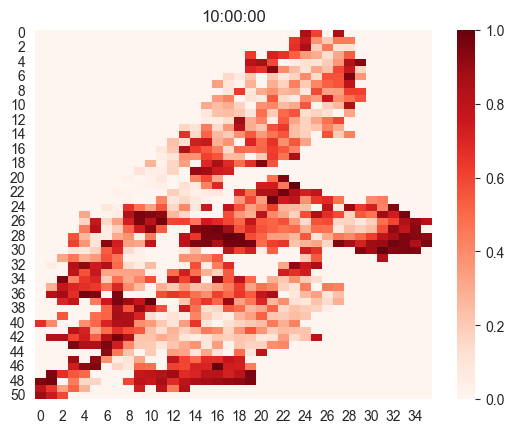

In [36]:
day = 9
files = os.listdir(f'rebalancing/data/{day}')
files.sort()
for i, file in enumerate(files[::3]):
    df = parameter.get_state_df(station_information, f'rebalancing/data/{day}/' + file,)
    split_file = file[:-7].split('-')
    hour = int(split_file[3])-4
    minute = int(split_file[4])
    if not 6 <= hour <= 10:
        continue
    if hour == 10 and minute != 0:
        continue
    model.init_df_state(df, time=timedelta(hours=(hour+minute/60)))
    if i < 10:
        i = f'00{i}'
    elif i < 100:
        i = f'0{i}'
    else:
        i = f'{i}'
    model.show_fill_percent(save=True, name=i)

In [37]:
os.system(f'magick images/fill/*.png fill_real_{day}th_6-10.gif')

0